# Stitch Two Networks with Different Spacing

This tutorial explains how to use the stitch function to not only combine two networks into a single domain, but to have OpenPNM automatically creat throats between the two domains based on the spatial proximity of pores on each network.


In [1]:
import numpy as np
import scipy as sp
import openpnm as op
%config InlineBackend.figure_formats = ['svg']
import openpnm.models.geometry as gm
import openpnm.models.physics as pm
import openpnm.models.misc as mm
import matplotlib.pyplot as plt
np.set_printoptions(precision=4)
np.random.seed(10)
ws = op.Workspace()
ws.settings["loglevel"] = 40
%matplotlib inline

## Generate Two Networks with Different Spacing

In [2]:
spacing_lg = 0.00006
layer_lg = op.network.Cubic(shape=[10, 10, 1], spacing=spacing_lg)

In [3]:
spacing_sm = 0.00002
layer_sm = op.network.Cubic(shape=[30, 5, 1], spacing=spacing_sm)

## Position Networks Appropriately, then Stitch Together

In [4]:
# Start by assigning labels to each network for identification later
layer_sm.set_label("small", pores=layer_sm.Ps, throats=layer_sm.Ts)
layer_lg.set_label("large", pores=layer_lg.Ps, throats=layer_lg.Ts)
# Next manually offset CL one full thickness relative to the GDL
layer_sm['pore.coords'] -= [0, spacing_sm*5, 0]
layer_sm['pore.coords'] += [0, 0, spacing_lg/2 - spacing_sm/2]  # And shift up by 1/2 a lattice spacing
# Finally, send both networks to stitch which will stitch CL onto GDL
from openpnm.topotools import stitch
stitch(network=layer_lg, donor=layer_sm,
       P_network=layer_lg.pores('back'),
       P_donor=layer_sm.pores('front'),
       len_max=0.00005)
combo_net = layer_lg
combo_net.name = 'combo'

## Quickly Visualize the Network
Let's just make sure things are working as planned using OpenPNMs basic visualization tools:

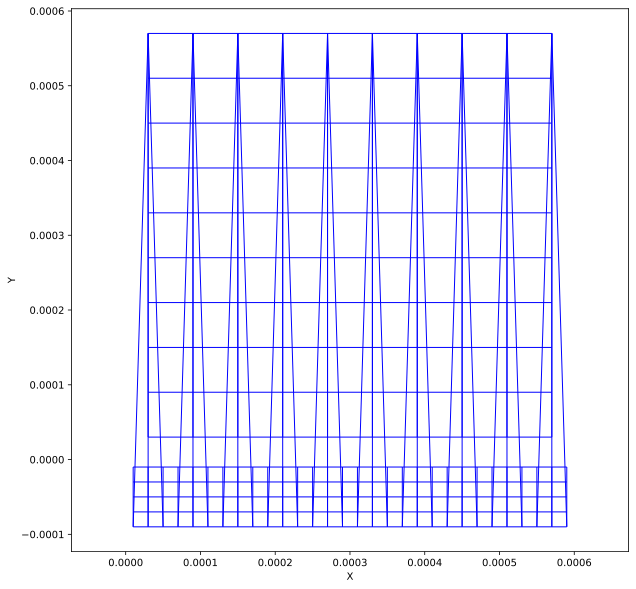

In [5]:
# NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(figsize=[10, 10])
op.topotools.plot_connections(network=combo_net, ax=ax)

## Create Geometry Objects for Each Layer

In [6]:
Ps = combo_net.pores('small')
Ts = combo_net.throats('small')
geom_sm = op.geometry.GenericGeometry(network=combo_net, pores=Ps, throats=Ts)
Ps = combo_net.pores('large')
Ts = combo_net.throats('small', mode='not')
geom_lg = op.geometry.GenericGeometry(network=combo_net, pores=Ps, throats=Ts)

### Add Geometrical Properties to the *Small* Domain
The *small* domain will be treated as a continua, so instead of assigning pore sizes we want the 'pore' to be same size as the lattice cell. 

In [7]:
geom_sm['pore.diameter'] = spacing_sm
geom_sm['pore.area'] = spacing_sm**2
geom_sm['throat.diameter'] = spacing_sm
geom_sm['throat.area'] = spacing_sm**2
geom_sm['throat.length'] = 1e-12  # A very small number to represent nearly 0-length
geom_sm.add_model(propname='throat.endpoints',
                  model=gm.throat_endpoints.circular_pores)
geom_sm.add_model(propname='throat.length',
                  model=gm.throat_length.piecewise)
geom_sm.add_model(propname='throat.conduit_lengths',
                  model=gm.throat_length.conduit_lengths)

### Add Geometrical Properties to the *Large* Domain

In [8]:
geom_lg['pore.diameter'] = spacing_lg*np.random.rand(combo_net.num_pores('large'))
geom_lg.add_model(propname='pore.area',
                  model=gm.pore_cross_sectional_area.sphere)
geom_lg.add_model(propname='throat.diameter',
                  model=mm.from_neighbor_pores,
                  prop='pore.diameter', mode='min')
geom_lg.add_model(propname='throat.area',
                  model=gm.throat_cross_sectional_area.cylinder)
geom_lg.add_model(propname='throat.endpoints',
                  model=gm.throat_endpoints.circular_pores)
geom_lg.add_model(propname='throat.length',
                  model=gm.throat_length.piecewise)
geom_lg.add_model(propname='throat.conduit_lengths',
                  model=gm.throat_length.conduit_lengths)

## Create Phase and Physics Objects

In [9]:
air = op.phases.Air(network=combo_net, name='air')
phys_lg = op.physics.GenericPhysics(network=combo_net, geometry=geom_lg, phase=air)
phys_sm = op.physics.GenericPhysics(network=combo_net, geometry=geom_sm, phase=air)

Add pore-scale models for diffusion to each Physics:

In [10]:
phys_lg.add_model(propname='throat.diffusive_conductance',
                  model=pm.diffusive_conductance.ordinary_diffusion)
phys_sm.add_model(propname='throat.diffusive_conductance',
                  model=pm.diffusive_conductance.ordinary_diffusion)

For the *small* layer we've used a normal diffusive conductance model, which when combined with the diffusion coefficient of air will be equivalent to open-air diffusion.  If we want the *small* layer to have some tortuosity we must account for this:

In [11]:
porosity = 0.5
tortuosity = 2
phys_sm['throat.diffusive_conductance'] *= (porosity/tortuosity)

Note that this extra line is NOT a pore-scale model, so it will be over-written when the `phys_sm` object is regenerated.

### Add a Reaction Term to the Small Layer
A standard n-th order chemical reaction is $ r=k \cdot x^b $, or more generally: $ r = A_1 \cdot x^{A_2} + A_3 $.  This model is available in `OpenPNM.Physics.models.generic_source_terms`, and we must specify values for each of the constants.

In [12]:
# Set Source Term
air['pore.A1'] = -1e-10  # Reaction pre-factor
air['pore.A2'] = 1  # Reaction order
air['pore.A3'] = 0  # A generic offset that is not needed so set to 0
phys_sm.add_model(propname='pore.reaction',
                  model=pm.generic_source_term.power_law,
                  A1='pore.A1', A2='pore.A2', A3='pore.A3',
                  X='pore.concentration', 
                  regen_mode='deferred')

## Perform a Diffusion Calculation

In [13]:
Deff = op.algorithms.ReactiveTransport(network=combo_net, phase=air)
Ps = combo_net.pores(['large', 'front'], mode='intersection')
Deff.set_value_BC(pores=Ps, values=1)
Ps = combo_net.pores('small')
Deff.set_source(propname='pore.reaction', pores=Ps)
Deff.settings['conductance'] = 'throat.diffusive_conductance'
Deff.settings['quantity'] = 'pore.concentration'
Deff.run()

## Visualize the Concentration Distribution

And the result would look something like this:

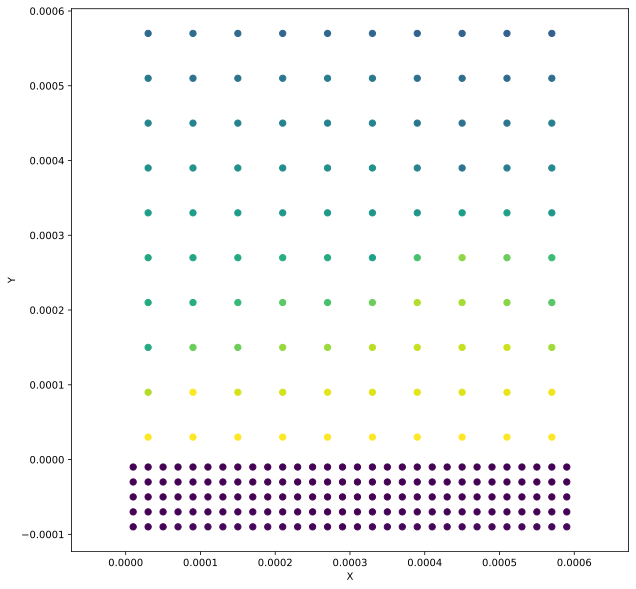

In [14]:
# NBVAL_IGNORE_OUTPUT
fig, ax = plt.subplots(figsize=[10, 10])
op.topotools.plot_coordinates(network=combo_net, c=Deff['pore.concentration'], 
                              cmap='jet', markersize=40, ax=ax)